# Exploration Strategies

Implementation of various action-selection methods that can be used to encourage exploration during the learning process.

In [1]:
# !pip install moviepy

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim

from helper import ExperienceBuffer, update_target, update_target_graph

### Load the environment

In [3]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Network implementation

In [4]:
class QNetwork(object):
    
    def __init__(self):
        # establish the feed-forward part of the network used to choose actions
        self.inputs = tf.placeholder(shape=[None, 4], dtype=tf.float32)
        self.temp = tf.placeholder(shape=None, dtype=tf.float32)
        self.keep_per = tf.placeholder(shape=None, dtype=tf.float32)
        
        hidden = slim.fully_connected(self.inputs, 64, activation_fn=tf.nn.tanh, 
                                      biases_initializer=None)
        hidden = slim.dropout(hidden, self.keep_per)
        self.q_out = slim.fully_connected(hidden, 2, activation_fn=None, 
                                          biases_initializer=None)
        self.predict = tf.argmax(self.q_out, 1)
        self.q_dist = tf.nn.softmax(self.q_out / self.temp)
        
        # obtain the loss by taking the sum of squares difference 
        # between the target and predicted Q-values
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, 2, dtype=tf.float32)
        self.q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_onehot), 
                               reduction_indices=1)
        self.next_q = tf.placeholder(shape=[None], dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.next_q - self.q))
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.update_op = optimizer.minimize(loss)

### Train the network

In [5]:
# hyperparams

exploration = 'greedy'  # exploration method ['greedy', 'random', 'e-greedy', 'boltzmann', 'bayesian']
gamma = 0.99  # discount factor
n_episodes = 20000  # number episodes to train network
tau = 0.001  # amount to update target network at each step
batch_size = 32  # size of training batch
start_epsilon = 1  # starting chance of random action
end_epsilon = 0.1  # final chance of random action
annealing_steps = 20000  # number training steps to reduce start_epsilon to end_epsilon
n_pretrain_steps = 50000  # number steps before training updates begin

In [6]:
def train():
    tf.reset_default_graph()
    main_network = QNetwork()
    target_network = QNetwork()
    trainables = tf.trainable_variables()
    target_ops = update_target_graph(trainables, tau)
    buffer = ExperienceBuffer()
    js, j_means, rewards, reward_means = [], [], [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        update_target(target_ops, sess)
        epsilon = start_epsilon
        step_drop = (start_epsilon - end_epsilon) / annealing_steps
        n_steps = 0
        for i in range(n_episodes):
            s = env.reset()
            total_reward = 0
            done = False
            j = 0
            while j < 999:
                j += 1
                if exploration == 'greedy':
                    # choose an action with the maximum expected value
                    a, all_q = sess.run([main_network.predict, main_network.q_out], feed_dict={
                        main_network.inputs: [s],
                        main_network.keep_per: 1.
                    })
                    a = a[0]
                elif exploration == 'random':
                    # choose an action randomly
                    a = env.action_space.sample()
                elif exploration == 'e-greedy':
                    # choose an action greedily from the Q-network, 
                    # with epsilon chance of random action
                    if np.random.rand(1) < epsilon or n_steps < n_pretrain_steps:
                        a = env.action_space.sample()
                    else:
                        a, all_q = sess.run([main_network.predict, main_network.q_out], feed_dict={
                            main_network.inputs: [s],
                            main_network.keep_per: 1.
                        })
                        a = a[0]
                elif exploration == 'boltzmann':
                    # choose an action probabilistically, with weights
                    # relative to the Q-values
                    q_d, all_q = sess.run([main_network.dist, main_network.q_out], feed_dict={
                        main_network.inputs: [s],
                        main_network.temp: epsilon,
                        main_network.keep_per: 1.
                    })
                    a = np.random.choice(q_d[0], p=q_d[0])
                    a = np.argmax(q_d[0] == a)
                elif exploration == 'bayesian':
                    # choose an action using a sample from a dropout approximation
                    # of a Bayesian Q-network
                    a, all_q = sess.run([main_network.predict, main_network.q_out], feed_dict={
                        main_network.inputs: [s],
                        main_network.keep_per: (1 - epsilon) + 0.1
                    })
                    a = a[0]
                    
                # get new state and reward from environment
                s1, reward, done, _ = env.step(a)
                buffer.add(np.reshape(np.array([s, a, reward, s1, done]), [1, 5]))
                
                if epsilon > end_epsilon and n_steps > n_pretrain_steps:
                    epsilon -= step_drop
                    
                if n_steps > n_pretrain_steps and n_steps % 5 == 0:
                    # using the Double-DQN training algorithm:
                    train_batch = buffer.sample(batch_size)
                    q1 = sess.run(main_network.predict, feed_dict={
                        main_network.inputs: np.vstack(train_batch[:, 3]),
                        main_network.keep_per: 1.
                    })
                    q2 = sess.run(target_network.q_out, feed_dict={
                        target_network.inputs: np.vstack(train_batch[:, 3]),
                        target_network.keep_per: 1.
                    })
                    end_multiplier = -train_batch[:, 4] - 1
                    double_q = q2[range(batch_size), q1]
                    target_q = train_batch[:, 2] + gamma * double_q * end_multiplier
                    _ = sess.run(main_network.update_op, feed_dict={
                        main_network.inputs: np.vstack(train_batch[:, 0]),
                        main_network.next_q: target_q,
                        main_network.keep_per: 1.,
                        main_network.actions: train_batch[:, 1]
                    })
                    update_target(target_ops, sess)
                    
                total_reward += reward
                s = s1
                n_steps += 1
                if done:
                    break
                    
            js.append(j)
            rewards.append(total_reward)
            if i % 100 == 0 and i != 0:
                reward_mean = np.mean(rewards[-100:])
                j_mean = np.mean(js[-100:])
                if exploration == 'e-greedy':
                    print('Mean reward:', str(reward_mean), 'Total steps:', str(n_steps), 'epsilon:', str(epsilon))
                elif exploration == 'boltzmann':
                    print('Mean reward:', str(reward_mean), 'Total steps:', str(n_steps), 't:', str(epsilon))
                elif exploration == 'bayesian':
                    print('Mean reward:', str(reward_mean), 'Total steps:', str(n_steps), 'p:', str(epsilon))
                elif exploration == 'random' or exploration == 'greedy':
                    print('Mean reward:', str(reward_mean), 'Total steps:', str(n_steps))
                    
                reward_means.append(reward_mean)
                j_means.append(j_mean)
                
    print('Successful episodes %:', str(sum(rewards) / n_episodes))
    
    return reward_means, j_means

In [7]:
reward_means, j_means = train()

Mean reward: 9.44 Total steps: 952
Mean reward: 9.38 Total steps: 1890
Mean reward: 9.39 Total steps: 2829
Mean reward: 9.47 Total steps: 3776
Mean reward: 9.43 Total steps: 4719
Mean reward: 9.38 Total steps: 5657
Mean reward: 9.39 Total steps: 6596
Mean reward: 9.41 Total steps: 7537
Mean reward: 9.33 Total steps: 8470
Mean reward: 9.32 Total steps: 9402
Mean reward: 9.5 Total steps: 10352
Mean reward: 9.45 Total steps: 11297
Mean reward: 9.37 Total steps: 12234
Mean reward: 9.44 Total steps: 13178
Mean reward: 9.52 Total steps: 14130
Mean reward: 9.46 Total steps: 15076
Mean reward: 9.39 Total steps: 16015
Mean reward: 9.5 Total steps: 16965
Mean reward: 9.42 Total steps: 17907
Mean reward: 9.38 Total steps: 18845
Mean reward: 9.54 Total steps: 19799
Mean reward: 9.43 Total steps: 20742
Mean reward: 9.45 Total steps: 21687
Mean reward: 9.51 Total steps: 22638
Mean reward: 9.45 Total steps: 23583
Mean reward: 9.45 Total steps: 24528
Mean reward: 9.45 Total steps: 25473
Mean reward: 9

### Performance statistics

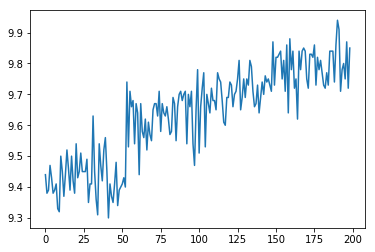

In [8]:
plt.plot(reward_means)

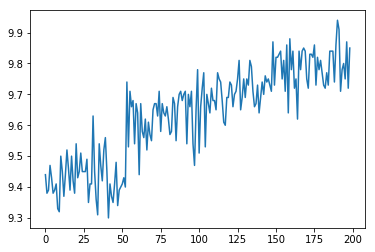

In [9]:
plt.plot(j_means)